In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from importlib import reload
plt.rcParams.update({'font.size': 14})
reload(filament)

<module 'filament.filament' from '../filament/filament.py'>

## Files and directories

In [2]:
datadir = "/data/SST/Global/DINEOF/"
eofdir = "/home/ctroupin/Software/DINEOF/MODIS_TERRA_SST_9km/"
datafile = os.path.join(datadir, "canary_sst.nc")
eoffile = os.path.join(eofdir, "eof.nc")
os.path.exists(eoffile) & os.path.exists(datafile)

True

### Projection

In [3]:
coordinates = (-20, -8., 25., 33.)
coordinates2 = (coordinates[0] - 0.5, coordinates[1] + 0.5, coordinates[2] - 0.5, coordinates[3] + 0.5)
m2 = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            resolution='f')

## Load data and EOFs

In [4]:
with netCDF4.Dataset(eoffile) as nc:
    U = nc.variables["Usst"][:]
    V = nc.variables["V"][:]
    sigma = nc.variables["Sigma"][:]

In [5]:
with netCDF4.Dataset(datafile) as nc:
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    sstanom = nc.variables["sstanom"][:]
    times = nc.variables["time"][:]
    timeunits = nc.variables["time"].units
    timeunits = timeunits.replace("seconds", "days")
    print(timeunits)
    dates = netCDF4.num2date(times, timeunits)
llon, llat = np.meshgrid(lon, lat)
lonp, latp = m2(llon, llat)

days since 1981-01-01 00:00:00


In [6]:
with netCDF4.Dataset(os.path.join(eofdir, "DINEOF_diagnostics.nc")) as nc:
    varEx = nc.variables["varEx"][:]

## Plot the EOFs
### 1st EOF
#### Temporal EOFs

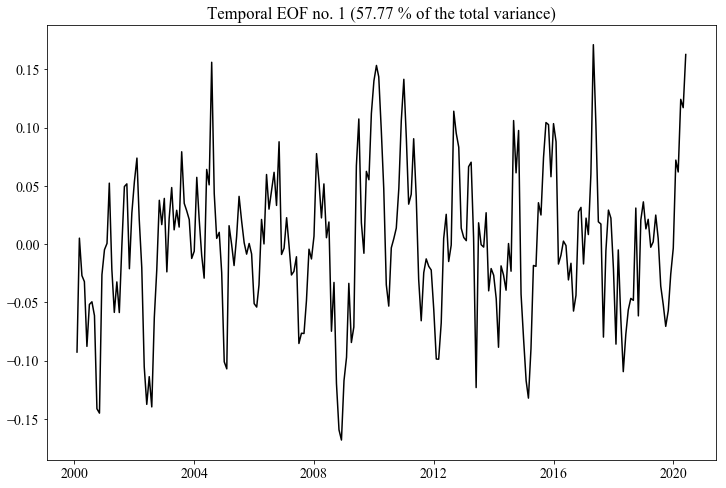

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.plot(dates, V[0], color="k")
plt.title("Temporal EOF no. {} ({:.2f} % of the total variance)".format(1, varEx[0]))
plt.show()
plt.close()

This mode is compared to the time series of the mean anomaly field.     
The two series are normalised by their standard deviation in order to make easier the comparison.

In [8]:
sst_anom_mean = [np.mean(sstanom[i,:,:]) for i in range(0, sstanom.shape[0])]

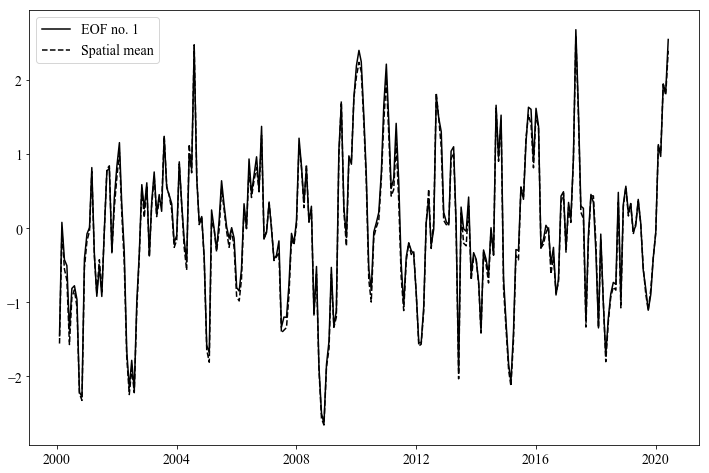

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.plot(dates, V[0] / np.sqrt(np.var(V[0])), color="k", label="EOF no. 1")
plt.plot(dates, sst_anom_mean / np.sqrt(np.var(sst_anom_mean)), 
         color="k", linestyle="--", label="Spatial mean")
plt.legend()
plt.show()

In [10]:
np.sqrt(np.sum((V[0] / np.sqrt(np.var(V[0]))) - (sst_anom_mean / np.sqrt(np.var(sst_anom_mean))))**2)

14.696959287536945

The correlation coefficient is above 99%:

In [11]:
np.corrcoef(sst_anom_mean, V[0])[0,1]

0.997679037041309

#### Spatial EOF

In [12]:
def plot_sst_anom(lonp, latp, sstanom, figtitle=None, **kwargs):
    """
    Plot the temperature anomaly field
    """
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    m2.pcolormesh(lonp, latp, sstanom, cmap=plt.cm.RdBu_r, **kwargs)
    plt.colorbar(extend="both")
    m2.fillcontinents(zorder=3)
    m2.drawcoastlines(linewidth=.2, color="k", zorder=4)
    m2.drawparallels(np.arange(25., 33., 2.), dashes=[1, 1], labels=[1, 0, 0, 0], zorder=2, linewidth=.5)
    m2.drawmeridians(np.arange(-20., -8., 4.), dashes=[2, 2], labels=[0, 0, 0, 1], zorder=2, linewidth=.5)
    plt.title(figtitle)
    plt.show()
    plt.close()

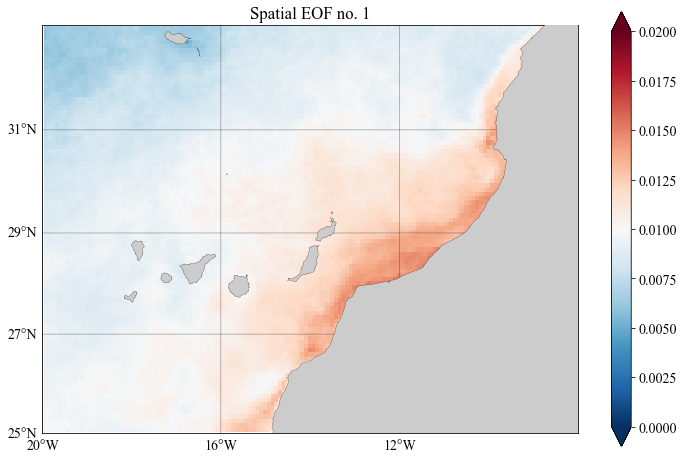

In [13]:
plot_sst_anom(lonp, latp, U[0,:,:], figtitle="Spatial EOF no. 1", vmin=0, vmax=0.02)

The EOF displays a temperature structure with constrasted values along the coast and offshore, though the coastal upwelling does not clearly appear.       
We also compare it to the temporal mean of the SST anomalies.

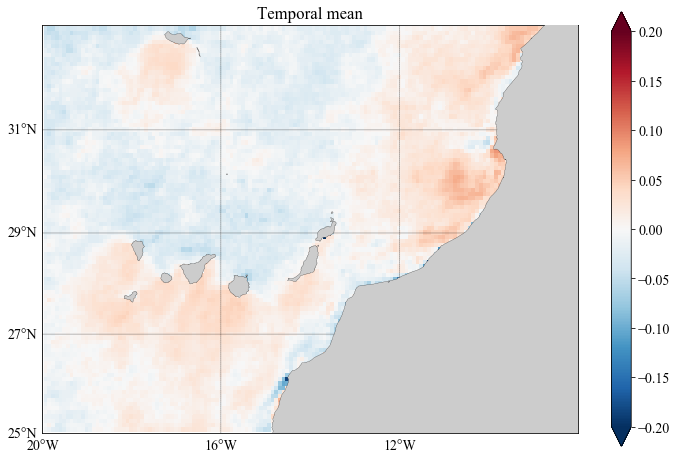

In [14]:
sst_anom_time_mean = np.mean(sstanom, axis=0)
plot_sst_anom(lonp, latp, sst_anom_time_mean - sst_anom_time_mean.mean(), 
              figtitle="Temporal mean", vmin=-.2, vmax=.2)

The 2 fields don't exhibit similarities: the temporal mean highlights the island wakes (higher temperature) and another region, east of 12°W, with positive anomalies.

### 2nd EOF
#### Temporal EOF

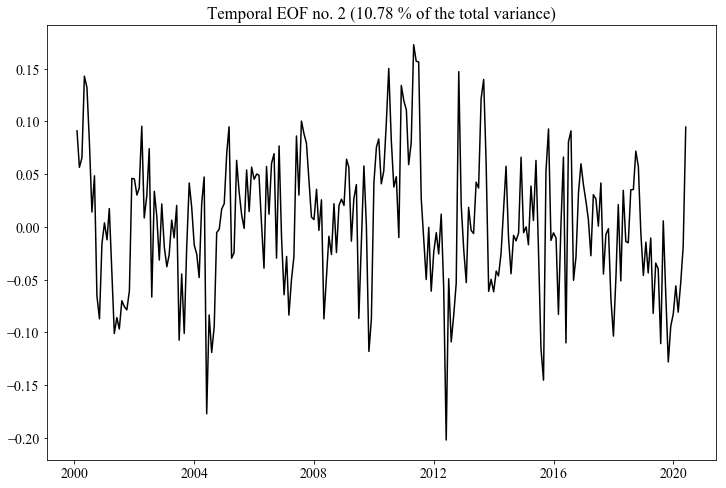

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.plot(dates, V[1], color="k")
plt.title("Temporal EOF no. {} ({:.2f} % of the total variance)".format(2, varEx[1]))
plt.show()

#### Spatial EOF

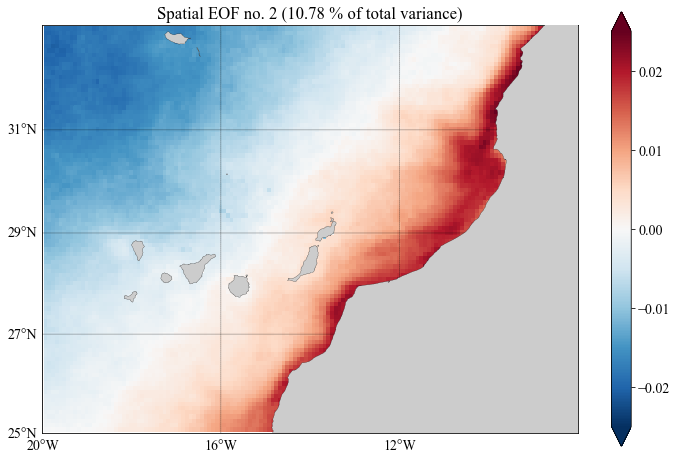

In [16]:
plot_sst_anom(lonp, latp, U[1,:,:], 
              figtitle="Spatial EOF no. 2 ({:.2f} % of total variance)".format(varEx[1]), 
              vmin=-0.025, vmax=0.025)

This mode depects the difference between coastal waters (upwelling) and the open ocean.     
We look at the extremal values of the series:

In [17]:
indmin = np.argmin(V[1])
indmax = np.argmax(V[1])
dates[indmin], dates[indmax]

(datetime.datetime(2012, 6, 1, 0, 0), datetime.datetime(2011, 5, 1, 0, 0))

* June 2012 and 
* May 2011.      

On June 2012, the 2nd EOF has its smallest value (negative) and the corresponding SST anomaly field display a strong coastal upwelling and the possible signature of filaments, with the offshore extension of cool water.

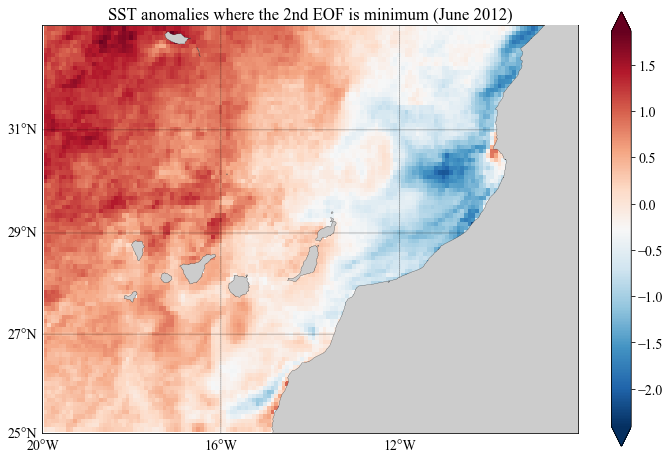

In [18]:
datetitle = " ".join((calendar.month_name[dates[indmin].month], str(dates[indmin].year)))
plot_sst_anom(lonp, latp, sstanom[indmin,:,:], 
              "SST anomalies where the 2nd EOF is minimum ({})".format(datetitle))

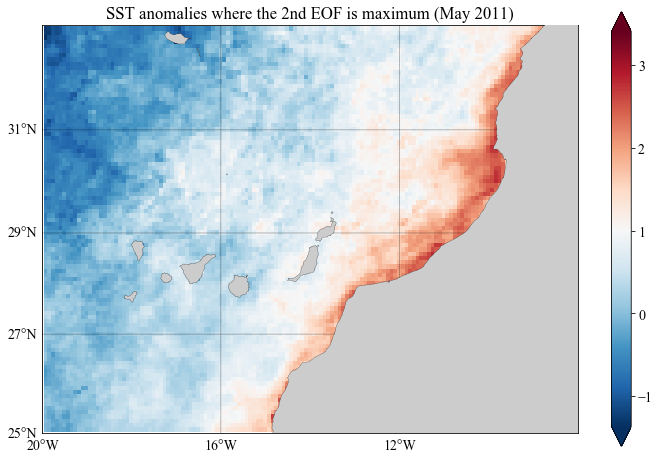

In [19]:
datetitle = " ".join((calendar.month_name[dates[indmax].month], str(dates[indmax].year)))

plot_sst_anom(lonp, latp, sstanom[indmax,:,:], 
              "SST anomalies where the 2nd EOF is maximum ({})".format(datetitle))

Here we have positive temperature anomalies along the coast, signal of a weakened upwelling.     
This hypothesis will be checked by assessing the wind field for that period.

### 3rd EOF
#### Temporal EOF

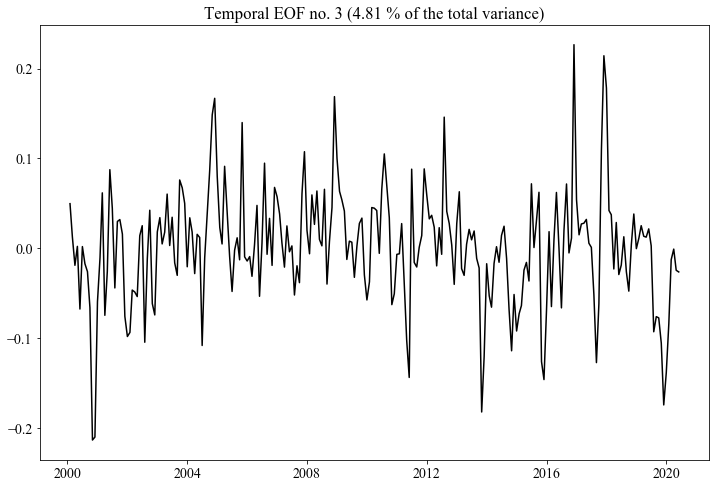

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.plot(dates, V[2], color="k")
plt.title("Temporal EOF no. 3 ({:.2f} % of the total variance)".format(varEx[2]))
plt.show()

#### Spatial EOF

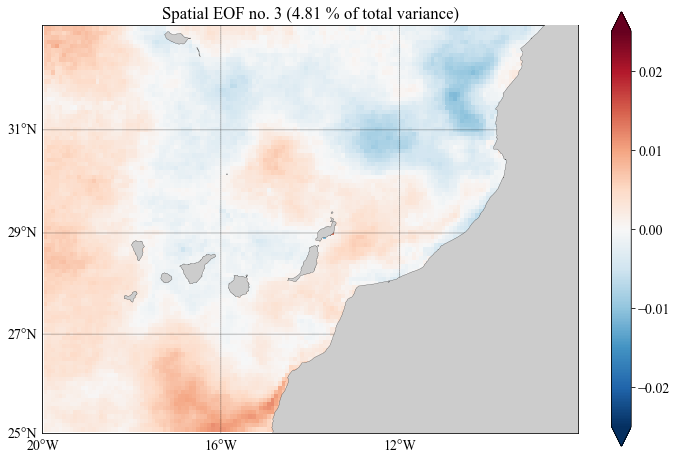

In [21]:
plot_sst_anom(lonp, latp, U[2,:,:], 
              figtitle="Spatial EOF no. 3 ({:.2f} % of total variance)".format(varEx[2]), 
              vmin=-0.025, vmax=0.025)

The 3rd EOF has no obvious interpretation. It displays alternate zones of positive and negative anomalies that we cannot easily relate to physical processes. 

### 4th mode
#### Temporal EOF

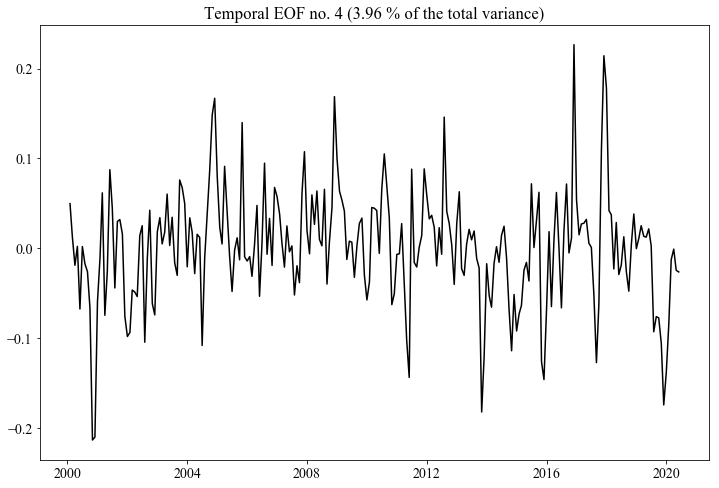

In [22]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.plot(dates, V[2], color="k")
plt.title("Temporal EOF no. 4 ({:.2f} % of the total variance)".format(varEx[3]))
plt.show()

#### Spatial EOF

plot_sst_anom(lonp, latp, U[3,:,:], 
              figtitle="Spatial EOF no. 4 ({:.2f} % of total variance)".format(varEx[3]), 
              vmin=-0.025, vmax=0.025)